<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MultiphaseflowMeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Multiphase flow measurements
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
%matplotlib inline

# Multiphase flow measurement
A multiphase flow meter is a device used to measure the individual phase flow rates of constituent phases in a given flow (for example in oil and gas industry) where oil, water and gas mixtures are initially co-mingled together during the oil production processes.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Multiphase_flow_meter


HANDBOOK OF MULTIPHASE FLOW METERING:

https://nfogm.no/wp-content/uploads/2014/02/MPFM_Handbook_Revision2_2005_ISBN-82-91341-89-3.pdf

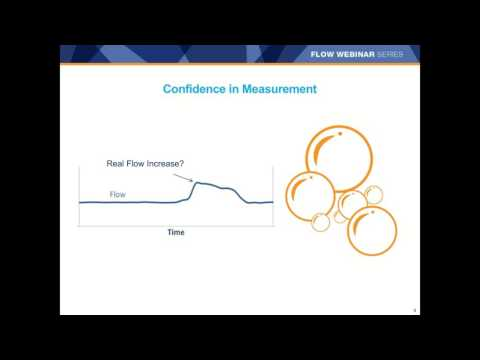

In [2]:
#@title Webinar: Advances in Multiphase Metering for Onshore Measurement in Oil & Gas
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('mcxrjJwidl0', width=600, height=400)

# Calculation of PVT properties for a multiphase flow meter

A typical multi phase flow meter will need calclation of various thermodynamic and physical properties. SUch properties have to be updated s the field is produced. The input to the property calculations are a characterized fluid composition from PVT studies.

The following script demonstrates calculation of PVT properties for a multi phase flow meter using a CHaracterized fluid composition.

                          total          gas          oil                     
           nitrogen  9.62653E-3   9.62653E-3   9.62653E-3      [mole fraction]
                CO2  6.83754E-3   6.83754E-3   6.83754E-3      [mole fraction]
            methane  9.49168E-1   9.49168E-1   9.49168E-1      [mole fraction]
             ethane  2.58407E-2   2.58407E-2   2.58407E-2      [mole fraction]
            propane  1.13959E-3   1.13959E-3   1.13959E-3      [mole fraction]
           i-butane  1.45947E-3   1.45947E-3   1.45947E-3      [mole fraction]
           n-butane  2.39914E-4   2.39914E-4   2.39914E-4      [mole fraction]
          i-pentane  7.79719E-4   7.79719E-4   7.79719E-4      [mole fraction]
          n-pentane  2.19921E-4   2.19921E-4   2.19921E-4      [mole fraction]
              C6_PC  6.59762E-4   6.59762E-4   6.59762E-4      [mole fraction]
              C7_PC   1.1096E-3    1.1096E-3    1.1096E-3      [mole fraction]
              C8_PC  1.06961E-3   1.06961E-3   1.069

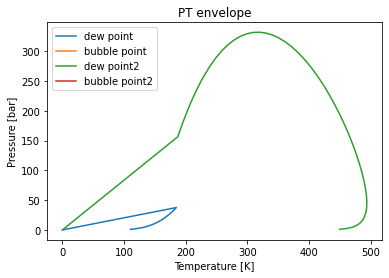

JavaObject id=o1702

In [29]:
names = ['nitrogen','CO2', 'methane', 'ethane', 'propane','i-butane','n-butane','i-pentane','n-pentane']
molefractions = [0.963, 0.684, 94.951, 2.585, 0.114, 0.146, 0.024, 0.078, 0.022]
fluidDefinedComponents = createfluid2(names, molefractions, "mol/sec")

charNames = ["C6", "C7", "C8", "C9", "C10"]
charFlowrate = [0.066, 0.111, 0.107, 0.047, 0.138]
molarMass = [86.18/1000.0, 96.0/1000.0, 107.0/1000.0, 121.0/1000.0, 200.0/1000.0]
density = [664.0e-3, 738.0e-3, 765.0e-3, 781.0e-3, 812.10e-3]
characterizedFluid = addOilFractions(fluidDefinedComponents, charNames,charFlowrate,molarMass,  density);
characterizedFluid.setHeavyTBPfractionAsPlusFraction()
characterizedFluid.getCharacterization().getLumpingModel().setNumberOfPseudoComponents(12);
characterizedFluid.getCharacterization().setLumpingModel("PVTlumpingModel");
characterizedFluid.getCharacterization().characterisePlusFraction();
characterizedFluid.setMixingRule(2)
characterizedFluid.init(0)
characterizedFluid
printFrame(characterizedFluid)
print('phase envelope for characterized fluid')
phaseenvelope(characterizedFluid, True)

## Generation of properties for multiphase measurements

The following script demonstrates how to generate typical properties for a multiphase flow meter.

In [30]:
import numpy
import numpy as np

pressures = [150.0, 170.0, 180.0, 200.0, 270.0]
temperatures = [30.0, 40.0, 50.0, 60.0, 80.0]

numP = len(pressures)
numT = len(temperatures)

gasViscosity = numpy.zeros((numP, numT))
oilViscosity = numpy.zeros((numP, numT))
gasDensity = numpy.zeros((numP, numT))
oilDensity = numpy.zeros((numP, numT))

gasViscosity[:] = np.NaN
oilViscosity[:] = np.NaN
gasDensity[:] = np.NaN
oilDensity[:] = np.NaN

for i in range(len(temperatures)):
  for j in range(len(pressures)):
    characterizedFluid.setPressure(pressures[j])
    characterizedFluid.setTemperature(temperatures[i]+273.15)
    TPflash(characterizedFluid)
    characterizedFluid.initProperties()
    if(characterizedFluid.hasPhaseType("gas")):
      gasViscosity[j][i]=characterizedFluid.getPhase("gas").getViscosity("cP")
      gasDensity[j][i]=characterizedFluid.getPhase("gas").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("oil")):
      oilViscosity[j][i]=characterizedFluid.getPhase("oil").getViscosity("cP")
      oilDensity[j][i]=characterizedFluid.getPhase("oil").getDensity("kg/m3")

gasDensityDataFrame = pd.DataFrame(gasDensity,index=pressures, columns=temperatures)
oilDensityDataFrame = pd.DataFrame(oilDensity,index=pressures, columns=temperatures)
gasviscosityDataFrame = pd.DataFrame(gasViscosity,index=pressures, columns=temperatures)
oilviscosityDataFrame = pd.DataFrame(oilViscosity,index=pressures, columns=temperatures)


print("gas density")
print(gasDensityDataFrame.head())
print("oil density")
print(oilDensityDataFrame.head())
print("gas viscosity")
print(gasviscosityDataFrame.head())
print("oil viscosity")
print(oilviscosityDataFrame.head())

gas density
             30.0        40.0        50.0        60.0        80.0
150.0  122.649443  115.647274  109.584965  104.271963   95.362006
170.0  139.312104  131.310697  124.352916  118.242691  107.990331
180.0  147.300945  138.872801  131.518933  125.047140  114.170342
200.0  162.487005  153.361120  145.330855  138.221981  126.209116
270.0  206.903457  196.706859  187.427057  178.985459  164.288519
oil density
             30.0        40.0        50.0        60.0        80.0
150.0  689.072231  693.460010  697.772555  701.946741  709.739852
170.0  686.830961  691.200733  695.544307  699.797736  707.951416
180.0  686.562118  690.841384  695.141486  699.395720  707.694336
200.0  687.743124  691.702667  695.817510  700.008870  708.522953
270.0  710.283031  711.880150  714.196365  716.997100  723.113064
gas viscosity
           30.0      40.0      50.0      60.0      80.0
150.0  0.016692  0.016595  0.016563  0.016579  0.016716
170.0  0.017815  0.017605  0.017480  0.017420  0.017435
18